# ONNX side by side

The notebook compares two runtimes for the same ONNX and looks into differences at each step of the graph.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

In [3]:
%matplotlib inline

## The ONNX model

We convert kernel function used in [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html). First some values to use for testing.

In [4]:
import numpy
import pandas
from io import StringIO

Xtest = pandas.read_csv(StringIO("""
1.000000000000000000e+02,1.061277971307766705e+02,1.472195004809226493e+00,2.307125069497626552e-02,4.539948095743629591e-02,2.855191098141335870e-01
1.000000000000000000e+02,9.417031896832908444e+01,1.249743892709246573e+00,2.370416174339620707e-02,2.613847280316268853e-02,5.097165413593484073e-01
1.000000000000000000e+02,9.305231488674536422e+01,1.795726729335217264e+00,2.473274733802270642e-02,1.349765645107412620e-02,9.410288840541443378e-02
1.000000000000000000e+02,7.411264142156210255e+01,1.747723020195752319e+00,1.559695663417645997e-02,4.230394035515055301e-02,2.225492746314280956e-01
1.000000000000000000e+02,9.326006195761877393e+01,1.738860294343326229e+00,2.280160135767652502e-02,4.883335335161764074e-02,2.806808409247734115e-01
1.000000000000000000e+02,8.341529291866362428e+01,5.119682123742423929e-01,2.488795768635816003e-02,4.887573336092913834e-02,1.673462179673477768e-01
1.000000000000000000e+02,1.182436477919874562e+02,1.733516391831658954e+00,1.533520930349476820e-02,3.131213519485807895e-02,1.955345358785769427e-01
1.000000000000000000e+02,1.228982583299257101e+02,1.115599996405831629e+00,1.929354155079938959e-02,3.056996308544096715e-03,1.197052763998271013e-01
1.000000000000000000e+02,1.160303269386108838e+02,1.018627021014927303e+00,2.248784981616459844e-02,2.688111547114307651e-02,3.326105131778724355e-01
1.000000000000000000e+02,1.163414374640396005e+02,6.644299545804077667e-01,1.508088417713602906e-02,4.451836657613789106e-02,3.245643044204808425e-01
""".strip("\n\r ")), header=None).values

Then the kernel.

In [5]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK, Sum

ker = Sum(
    CK(0.1, (1e-3, 1e3)) * RBF(length_scale=10,
                               length_scale_bounds=(1e-3, 1e3)),
    CK(0.1, (1e-3, 1e3)) * RBF(length_scale=1,
                               length_scale_bounds=(1e-3, 1e3))
)

ker

0.316**2 * RBF(length_scale=10) + 0.316**2 * RBF(length_scale=1)

In [6]:
ker(Xtest)

array([[2.00000000e-01, 4.88993040e-02, 4.25048140e-02, 5.94472678e-04,
        4.36813578e-02, 7.54738292e-03, 4.79816083e-02, 2.44870899e-02,
        6.11804858e-02, 5.91636643e-02],
       [4.88993040e-02, 2.00000000e-01, 1.41439850e-01, 1.33559792e-02,
        1.56539930e-01, 5.58967934e-02, 5.50622994e-03, 1.61259456e-03,
        9.16550083e-03, 8.54623880e-03],
       [4.25048140e-02, 1.41439850e-01, 2.00000000e-01, 1.66351088e-02,
        1.95919797e-01, 6.23358040e-02, 4.18740453e-03, 1.16061688e-03,
        7.11297248e-03, 6.59679571e-03],
       [5.94472678e-04, 1.33559792e-02, 1.66351088e-02, 2.00000000e-01,
        1.59911246e-02, 6.43812362e-02, 5.90141166e-06, 6.77520700e-07,
        1.52525053e-05, 1.33384349e-05],
       [4.36813578e-02, 1.56539930e-01, 1.95919797e-01, 1.59911246e-02,
        2.00000000e-01, 6.11287461e-02, 4.41158561e-03, 1.23488073e-03,
        7.46433076e-03, 6.92846776e-03],
       [7.54738292e-03, 5.58967934e-02, 6.23358040e-02, 6.43812362e-02,
   

## Conversion to ONNX

The function is not an operator, the function to use is specific to this usage.

In [7]:
from skl2onnx.operator_converters.gaussian_process import convert_kernel
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx.algebra.onnx_ops import OnnxIdentity
onnx_op = convert_kernel(ker, 'X', output_names=['final_after_op_Add'],
                         dtype=numpy.float32, op_version=10)
onnx_op = OnnxIdentity(onnx_op, output_names=['Y'])
model_onnx = model_onnx = onnx_op.to_onnx(
                inputs=[('X', FloatTensorType([None, None]))])

with open("model_onnx.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

``[('X', FloatTensorType([None, None]))]`` means the function applies on every tensor whatever its dimension is.

In [8]:
%onnxview model_onnx

In [9]:
from mlprodict.onnxrt import OnnxInference
pyrun = OnnxInference(model_onnx)
rtrun = OnnxInference(model_onnx, runtime="onnxruntime1")

In [10]:
pyres = pyrun.run({'X': Xtest.astype(numpy.float32)})
pyres

{'Y': array([[2.00000003e-01, 4.88993339e-02, 4.25047986e-02, 5.94472338e-04,
         4.36813496e-02, 7.54737947e-03, 4.79816124e-02, 2.44870633e-02,
         6.11804537e-02, 5.91636561e-02],
        [4.88993339e-02, 2.00000003e-01, 1.41439855e-01, 1.33559676e-02,
         1.56540006e-01, 5.58967553e-02, 5.50623611e-03, 1.61259342e-03,
         9.16550029e-03, 8.54624342e-03],
        [4.25047986e-02, 1.41439855e-01, 2.00000003e-01, 1.66351143e-02,
         1.95919767e-01, 6.23358004e-02, 4.18740092e-03, 1.16061396e-03,
         7.11296080e-03, 6.59678876e-03],
        [5.94472338e-04, 1.33559676e-02, 1.66351143e-02, 2.00000003e-01,
         1.59911271e-02, 6.43812567e-02, 5.90140644e-06, 6.77518699e-07,
         1.52524681e-05, 1.33384119e-05],
        [4.36813496e-02, 1.56540006e-01, 1.95919767e-01, 1.59911271e-02,
         2.00000003e-01, 6.11287355e-02, 4.41158377e-03, 1.23487751e-03,
         7.46431900e-03, 6.92846393e-03],
        [7.54737947e-03, 5.58967553e-02, 6.23358004e-02

In [11]:
rtres = rtrun.run({'X': Xtest.astype(numpy.float32)})
rtres

{'Y': array([[2.00000003e-01, 4.88993339e-02, 4.25047949e-02, 5.94472338e-04,
         4.36813496e-02, 7.54737947e-03, 4.79816124e-02, 2.44870633e-02,
         6.11804537e-02, 5.91636561e-02],
        [4.88993339e-02, 2.00000003e-01, 1.41439855e-01, 1.33559629e-02,
         1.56540006e-01, 5.58967553e-02, 5.50623611e-03, 1.61259342e-03,
         9.16550029e-03, 8.54624342e-03],
        [4.25047949e-02, 1.41439855e-01, 2.00000003e-01, 1.66351162e-02,
         1.95919767e-01, 6.23358004e-02, 4.18740092e-03, 1.16061396e-03,
         7.11296080e-03, 6.59678876e-03],
        [5.94472338e-04, 1.33559629e-02, 1.66351162e-02, 2.00000003e-01,
         1.59911271e-02, 6.43812492e-02, 5.90140644e-06, 6.77518699e-07,
         1.52524681e-05, 1.33384119e-05],
        [4.36813496e-02, 1.56540006e-01, 1.95919767e-01, 1.59911271e-02,
         2.00000003e-01, 6.11287355e-02, 4.41158330e-03, 1.23487751e-03,
         7.46431900e-03, 6.92846393e-03],
        [7.54737947e-03, 5.58967553e-02, 6.23358004e-02

In [12]:
from mlprodict.onnxrt.validate.validate_difference import measure_relative_difference
measure_relative_difference(pyres['Y'], rtres['Y'])

1.15725925e-07

The last runtime uses [onnxruntime](https://github.com/microsoft/onnxruntime) to run every node independently from each others.

In [13]:
rt_partial_run = OnnxInference(model_onnx, runtime="onnxruntime1")
rt_partial_res = rt_partial_run.run({'X': Xtest.astype(numpy.float32)})
measure_relative_difference(pyres['Y'], rt_partial_res['Y'])

1.15725925e-07

## Side by side

We run every node independently and we compare the output at each step.

In [14]:
%matplotlib inline

In [15]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
from pandas import DataFrame

def run_sbs(r1, r2, r3, x):
    sbs = side_by_side_by_values([r1, r2, r3], 
                                 inputs={'X': x.astype(numpy.float32)})
    df = DataFrame(sbs)
    dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
    dfd.loc[dfd.cmp == 'ERROR->=inf', 'v[1]'] = 10
    return dfd, sbs

dfd, _ = run_sbs(pyrun, rtrun, rt_partial_run, Xtest)
dfd

,metric,step,v[0],v[1],v[2],cmp,name,shape[0],shape[1],shape[2]
0,nb_results,-1,49,4.900000e+01,4.900000e+01,OK,NaN,NaN,NaN,NaN
1,abs-diff,0,0,0.000000e+00,0.000000e+00,OK,X,"(10, 6)","(10, 6)","(10, 6)"
2,abs-diff,1,0,0.000000e+00,0.000000e+00,OK,Ad_Addcst,"(1,)","(1,)","(1,)"
3,abs-diff,2,0,0.000000e+00,0.000000e+00,OK,Ad_Addcst1,"(1,)","(1,)","(1,)"
4,abs-diff,3,0,0.000000e+00,0.000000e+00,OK,Sh_shape0,"(2,)","(2,)","(2,)"
5,abs-diff,4,0,0.000000e+00,0.000000e+00,OK,Co_output0,"(10, 6)","(10, 6)","(10, 6)"
6,abs-diff,5,0,0.000000e+00,0.000000e+00,OK,Re_reduced0,"(10, 1)","(10, 1)","(10, 1)"
7,abs-diff,6,0,0.000000e+00,0.000000e+00,OK,Tr_transposed0,"(1, 10)","(1, 10)","(1, 10)"
8,abs-diff,7,0,1.000000e+00,1.000000e+00,ERROR->=1.0,Ma_Y0,"(10, 10)","(10, 10)","(10, 10)"
9,abs-diff,8,0,4.863269e+00,4.863269e+00,ERROR->=4.9,Ad_C0,"(10, 10)","(10, 10)","(10, 10)"


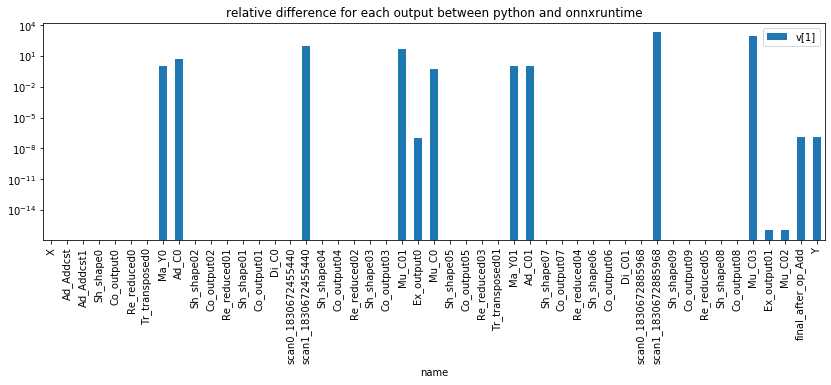

In [16]:
ax = dfd[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("relative difference for each output between python and onnxruntime");

Let's try for other inputs.

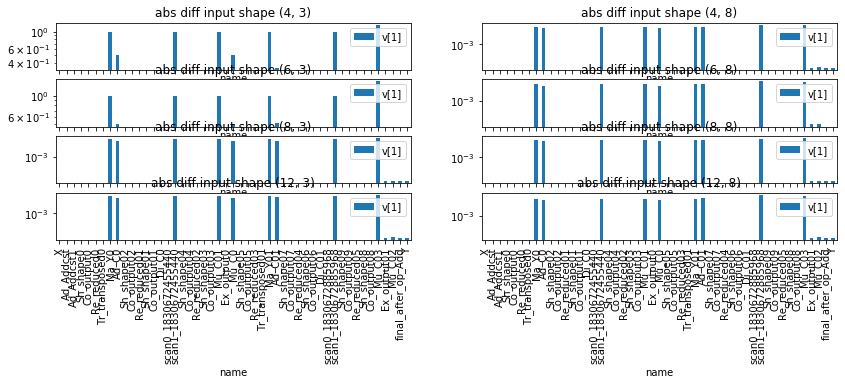

In [17]:
import matplotlib.pyplot as plt
values = [4, 6, 8, 12]
fig, ax = plt.subplots(len(values), 2, figsize=(14, len(values) * 4))

for i, d in enumerate(values):
    for j, dim in enumerate([3, 8]):
        mat = numpy.random.rand(d, dim)
        dfd, _ = run_sbs(pyrun, rtrun, rt_partial_run, mat)
        dfd[['name', 'v[1]']].iloc[1:].set_index('name').plot(
            kind='bar', figsize=(14,4), logy=True, ax=ax[i, j])
        ax[i, j].set_title("abs diff input shape {}".format(mat.shape))
        if i < len(values) - 1:
            for xlabel_i in ax[i, j].get_xticklabels():
                xlabel_i.set_visible(False)

## Further analysis

If there is one issue, we can create a simple graph to test. We consider ``Y = A + B`` where *A* and *B* have the following name in the *ONNX* graph:

In [18]:
node = pyrun.sequence_[-2].onnx_node
final_inputs = list(node.input)
final_inputs

['Mu_C0', 'Mu_C02']

In [19]:
_, sbs = run_sbs(pyrun, rtrun, rt_partial_run, Xtest)

names = final_inputs + ['Y']
values = {}
for row in sbs:
    if row.get('name', '#') not in names:
        continue
    name = row['name']
    values[name] = [row["value[%d]" % i] for i in range(3)]

list(values.keys())

['Mu_C0', 'Mu_C02', 'Y']

Let's check.

In [20]:
for name in names:
    if name not in values:
        raise Exception("Unable to find '{}' in\n{}".format(
            name, [_.get('name', "?") for _ in sbs]))

a, b, c = names
for i in [0, 1, 2]:
    A = values[a][i]
    B = values[b][i]
    Y = values[c][i]
    diff = Y - (A + B)
    dabs = numpy.max(numpy.abs(diff))
    print(i, diff.dtype, dabs)

0 float32 0.10000001
1 float32 0.0
2 float32 0.0


If the second runtime has issue, we can create a single node to check something.

In [21]:
from skl2onnx.algebra.onnx_ops import OnnxAdd
onnx_add = OnnxAdd('X1', 'X2', output_names=['Y'])
add_onnx = onnx_add.to_onnx({'X1': A, 'X2': B})

In [22]:
pyrun_add = OnnxInference(add_onnx)
rtrun_add = OnnxInference(add_onnx, runtime="onnxruntime1")

In [23]:
res1 = pyrun_add.run({'X1': A, 'X2': B})
res2 = rtrun_add.run({'X1': A, 'X2': B})

In [24]:
measure_relative_difference(res1['Y'], res2['Y'])

0.0

No mistake here.

## onnxruntime

In [25]:
from onnxruntime import InferenceSession, RunOptions, SessionOptions
opt = SessionOptions()
opt.enable_mem_pattern = True
opt.enable_cpu_mem_arena = True
sess = InferenceSession(model_onnx.SerializeToString(), opt)
sess

In [26]:
res = sess.run(None, {'X': Xtest.astype(numpy.float32)})[0]
measure_relative_difference(pyres['Y'], res)

1.15725925e-07

In [27]:
res = sess.run(None, {'X': Xtest.astype(numpy.float32)})[0]
measure_relative_difference(pyres['Y'], res)

1.15725925e-07

## Side by side for MLPRegressor

In [28]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = MLPRegressor()
clr.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [29]:
from mlprodict.onnx_conv import to_onnx
onx = to_onnx(clr, X_train.astype(numpy.float32))

In [30]:
pyrun = OnnxInference(onx, runtime="python")
rtrun = OnnxInference(onx, runtime="onnxruntime1")
rt_partial_run = OnnxInference(onx, runtime="onnxruntime2")
dfd, _ = run_sbs(rtrun, rt_partial_run, pyrun, X_test)
dfd

,metric,step,v[0],v[1],v[2],cmp,name,shape[0],shape[1],shape[2]
0,nb_results,-1,14,14.0,1.400000e+01,OK,NaN,NaN,NaN,NaN
1,abs-diff,0,0,0.0,0.000000e+00,OK,X,"(38, 4)","(38, 4)","(38, 4)"
2,abs-diff,1,0,0.0,0.000000e+00,OK,coefficient,"(4, 100)","(4, 100)","(4, 100)"
3,abs-diff,2,0,0.0,0.000000e+00,OK,intercepts,"(1, 100)","(1, 100)","(1, 100)"
4,abs-diff,3,0,0.0,0.000000e+00,OK,coefficient1,"(100, 1)","(100, 1)","(100, 1)"
5,abs-diff,4,0,0.0,0.000000e+00,OK,intercepts1,"(1, 1)","(1, 1)","(1, 1)"
6,abs-diff,5,0,0.0,0.000000e+00,OK,shape_tensor,"(2,)","(2,)","(2,)"
7,abs-diff,6,0,0.0,0.000000e+00,OK,cast_input,"(38, 4)","(38, 4)","(38, 4)"
8,abs-diff,7,0,0.0,1.000000e+00,ERROR->=1.0,mul_result,"(38, 100)","(38, 100)","(38, 100)"
9,abs-diff,8,0,0.0,1.000000e+00,ERROR->=1.0,add_result,"(38, 100)","(38, 100)","(38, 100)"


In [31]:
%onnxview onx